In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [3]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [4]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [5]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').astype(float)

## 2. Add Features

In [6]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [7]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)
df.is_untitled.value_counts()

0    16574
1     6137
Name: is_untitled, dtype: int64

In [8]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [9]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

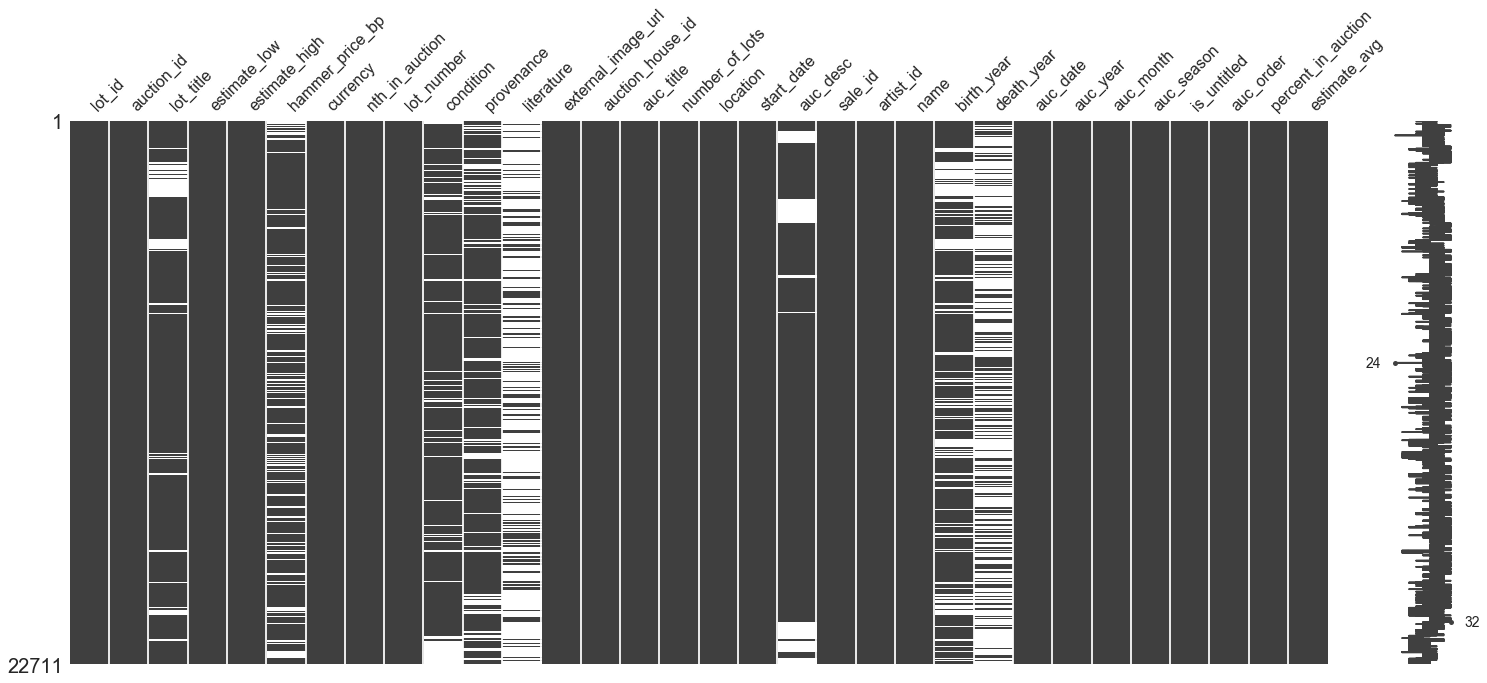

In [10]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

msno.matrix(df)

## 3. Convert Currency

In [11]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

In [12]:
df.sample(20)

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd
22143,903,6,UNTITLED,80000.0,120000.0,432000.0,HKD,35,535,NaN,NaN,NaN,http://www.sothebys.com/content/dam/default/un...,1,Chinese Contemporary Art,132,HONG KONG,2006-04-08 02:30:02.000,NaN,K0230,629,Yang Shaobin B. 1963,1963.0,NaN,2006-04-08,2006,4,2,1,3,26.5,100000.0,55692.21,10313.37,15470.06,12891.72
8351,12074,183,COMÉDIES ET PROVERBES,80000.0,120000.0,NaN,USD,60,160,This work is in very good and sound condition ...,"Private Collection<br>Christie's, New York, Ap...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day Auction,464,NEW YORK,2012-11-14 14:30:00.604,OVERVIEW\n\nTHE CONTEMPORARY ART DAY AUCTION /...,N08901,1412,Joseph Cornell,1903.0,1972,2012-11-14,2012,11,4,0,1,12.9,100000.0,NaN,80000.00,120000.00,100000.00
15448,4664,73,NUDE SUNBATHING,NaN,NaN,24000000.0,NaN,8,8,NaN,"Gagosian Gallery, New York<br>Acquired by the ...",A radiant vision of exquisite beauty and devas...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,50,NEW YORK,2017-05-18 23:00:00.715,Results: Our Contemporary Art Evening Auction ...,N09761,27,Roy Lichtenstein,1923.0,1997,2017-05-18,2017,5,2,0,4,16.0,NaN,24000000.00,NaN,NaN,NaN
22027,886,7,FOCUS #43,35000.0,55000.0,57600.0,USD,27,27,NaN,"<p>Private Collection, Europe</p>",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Asia,309,NEW YORK,2007-03-21 14:00:56.000,NaN,N08298,659,Lin Tianmiao,1961.0,NaN,2007-03-21,2007,3,2,0,1,8.7,45000.0,57600.00,35000.00,55000.00,45000.00
18333,3408,45,PENETRATION,5000.0,7000.0,27500.0,USD,268,529,This work is in very good condition overall. T...,"Andrea Rosen Gallery, New York<br>Acquired fro...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day Auction,313,NEW YORK,2016-11-18 15:00:00.489,Sotheby’s Contemporary Art Day Auction on 18 N...,N09573,1041,Michael Raedecker,1963.0,NaN,2016-11-18,2016,11,4,0,9,85.6,6000.0,27500.00,5000.00,7000.00,6000.00
9054,16231,177,IN VERGUNBENHERT,10000.0,15000.0,NaN,USD,278,287,This work is in very good condition overall. T...,"<p>Monika Sprüth Galerie, Cologne<br>Robert Mi...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,298,NEW YORK,2012-03-09 15:00:00.841,OVERVIEW\n\nThe bi-annual Contemporary sale is...,N08829,2069,Milan Kunc,1944.0,NaN,2012-03-09,2012,3,2,0,9,93.3,12500.0,NaN,10000.00,15000.00,12500.00
16360,4105,68,LE SONGE,4000.0,6000.0,7500.0,GBP,72,173,"Executed on cream wove paper, not laid down an...",The authenticity of this work has been confirm...,NaN,http://www.sothebys.com/content/dam/stb/lots/L...,1,Impressionist & Modern Art Day Sale,208,LONDON,2017-06-22 09:30:00.361,The Impressionist and Modern Art Day Sale is h...,L17008,1820,Léonard Tsuguharu Foujita,1886.0,1968,2017-06-22,2017,6,3,0,3,34.6,5000.0,9500.90,5067.14,7600.72,6333.93
10148,14614,172,JULIUS CAESAR (FROM THE SERIES ROYAL BLOOD),8000.0,12000.0,7500.0,EUR,105,122,NaN,"<p>Galerie Reflex, Amsterdam<br>Acquired from ...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Modern & Contemporary Art,108,AMSTERDAM,2011-05-17 12:00:00.280,OVERVIEW\n\nWith a wide selection of paintings...,M1099,5259,Erwin Olaf,1959.0,NaN,2011-05-17,2011,5,2,0,10,97.2,10000.0,10628.25,11336.80,17005.20,14171.00
4940,14907,197,AVENZA,250000.0,350000.0,470500.0,USD,68,175,This work is in very good and sound condition ...,One cast from this edition is in the permanent...,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day,372,NEW YORK,2011-05-11 14:00:00.953,OVERVIEW\n\nThe May 11th

## 4. Export to CSV

In [13]:
df.to_csv("final_sothebys.csv")